In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from IPython.display import Image, Markdown, display
pd.options.display.max_rows = 999

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

import time
pd.options.display.max_rows = 999




C:\Users\PMAC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\PMAC\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Theatrical Box Office Forecasting



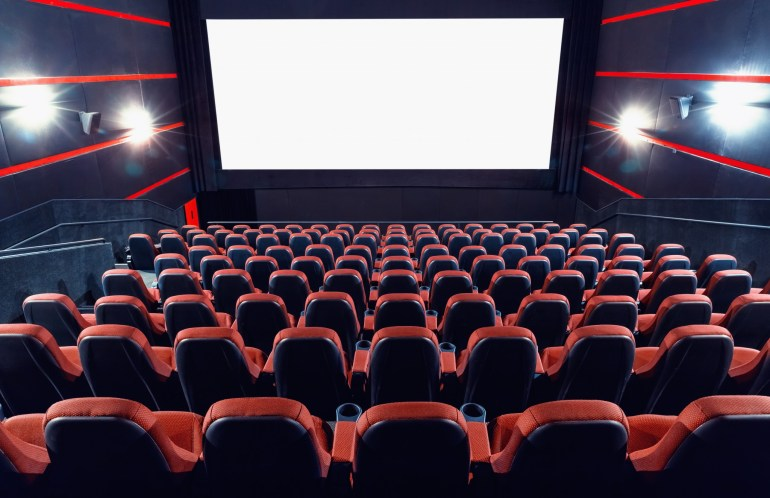

In [2]:
display(Image('image/1.jpg'))

# The data

* Total grosses by film
* Metadata about the film

# The approach

Use metadata to inform theatrical performance pre-release

In other words, value the asset early


## EDA

In [3]:
# Import the data, set a master copy in case
df_master = pd.read_csv('data/rentrak_grosses.csv')
df = df_master.copy()

In [4]:
# Inspect the data
# Missing values, lots of objects
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 28 columns):
Title                             7907 non-null object
Rating                            7610 non-null object
Academy Awards                    108 non-null object
Actors                            6178 non-null object
Categories                        7875 non-null object
Detailed_Release                  7844 non-null object
Directors                         7761 non-null object
Dist                              7907 non-null object
Distributor Long Name             7907 non-null object
Year(DVD/Video Release Date)      5249 non-null float64
Golden Globes                     69 non-null object
Language                          7793 non-null object
Producers                         6069 non-null object
Production Companies              2449 non-null object
Quarter(Release Date)             7674 non-null object
Sound Formats                     4638 non-null object
Visual Formats 

In [5]:
# Inspect the data, one observation
# Some data points represented as lists (with commas)
# Some non-integer columns (also with commas)
df.iloc[182]

Title                                                                      whiplash
Rating                                                                            r
Academy Awards                    best film editing, best sound mixing, best sup...
Actors                            j.k. simmons, melissa benoist, miles teller, p...
Categories                                                                    drama
Detailed_Release                                                         10/10/2014
Directors                                                           damien chazelle
Dist                                                                            spc
Distributor Long Name                                        sony pictures classics
Year(DVD/Video Release Date)                                                   2015
Golden Globes                                                 best supporting actor
Language                                                                    

In [6]:
# Data cleaning will need to occur. Review columns with multiple values

collist1 = ['Academy Awards', 'Categories','Golden Globes']
for i in collist1:
    display(Markdown(("""### """+i)))
    print(df[i].value_counts())

### Academy Awards

best documentary                                                                                                                          9
best animated feature film                                                                                                                7
best supporting actress                                                                                                                   7
best actress                                                                                                                              5
best adapted screenplay                                                                                                                   4
best original screenplay                                                                                                                  4
best visual effects                                                                                                                       4
best costume design 

### Categories

documentary                                                                             1614
drama                                                                                   1197
comedy                                                                                   723
horror, suspense                                                                         296
comedy, drama                                                                            241
suspense                                                                                 207
special events                                                                           197
documentary, foreign                                                                     147
drama, suspense                                                                          138
drama, romance                                                                           134
comedy, romance                                                       

### Golden Globes

best actress - drama                                                                                                                  8
best actor - drama                                                                                                                    7
best supporting actress                                                                                                               6
best supporting actor                                                                                                                 6
best actor - musical or comedy                                                                                                        4
best actress - musical or comedy                                                                                                      4
best actor - musical or comedy, best picture - musical or comedy                                                                      3
best director                                   

In [7]:
# Columns with multiple values in 1 cell will need to be split into multiple columns instead, then converted to numbers
# Get all unique possible values from Academy Awards

vallist = []   # Create list to house all possible values
for index, row in df.iterrows():
    searchval = str(df['Academy Awards'].loc[index]) #loop through every row
    if searchval != 'nan':  # if not nan
        templist = [x.strip() for x in searchval.split(',')] # split & clean all values
        for item in templist:  # for each value not already in the master vallist
            if item not in vallist: # check
                vallist.append(item) # then add 
print(vallist) # returns all unique values   

['best actress', 'best art direction', 'best cinematography', 'best director', 'best score', 'best song', 'best film editing', 'best sound mixing', 'best supporting actor', 'best costume design', 'best makeup', 'best sound editing', 'best documentary', 'best adapted screenplay', 'best picture', 'best actor', 'best supporting actress', 'best animated feature film', 'best original screenplay', 'best visual effects', 'best foreign language film']


In [8]:
# Now dataframe will have all of these added as columns with a prefix. 
# This is different than dummies because of the manual process of having to split text.
# If they were all neatly in one column, dummies would be fine. 

for i in vallist:
    df['awards_'+i] = 0   # instatiate columns as int columns

In [9]:
# Now view output columns: 

df.columns

Index(['Title', 'Rating', 'Academy Awards', 'Actors', 'Categories',
       'Detailed_Release', 'Directors', 'Dist', 'Distributor Long Name',
       'Year(DVD/Video Release Date)', 'Golden Globes', 'Language',
       'Producers', 'Production Companies', 'Quarter(Release Date)',
       'Sound Formats', 'Visual Formats', 'Writers', 'Total Cume',
       'Total DVD/Video Release Window', 'Total Locs At Opening',
       'Total Locs At Widest Release', 'Total Opening 7 Day Gross',
       'Total Opening Day Gross', 'Total Opening Wknd Avg',
       'Total Opening Wknd Gross', 'Total Opening Wknd Locs', 'Total Run Time',
       'awards_best actress', 'awards_best art direction',
       'awards_best cinematography', 'awards_best director',
       'awards_best score', 'awards_best song', 'awards_best film editing',
       'awards_best sound mixing', 'awards_best supporting actor',
       'awards_best costume design', 'awards_best makeup',
       'awards_best sound editing', 'awards_best documentar

In [10]:
# Check each row for match then encode column appropriately 

for index, row in df.iterrows():
    searchval = str(df['Academy Awards'].loc[index]) #loop through every row
    if searchval != 'nan':  # if not nan
        templist = [x.strip() for x in searchval.split(',')]
        for item in templist:
            df['awards_'+item].loc[index] = 1

C:\Users\PMAC\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
# Check new data encoding:

df['awards_best film editing'].loc[182]
df['awards_best actor'].loc[182]

0

In [12]:
# repeat same process for categories (genres) and golden globes:

def encode_list(newval, matchval):
    print(newval)
    striplist = [x.strip() for x in newval.split(',')]
    if matchval in striplist: # split & clean all values
        return 1
    else:
        return 0
            
# Why won't this work? Passing in full series on the lambda function...? 

    
    
def handle_column_split_new(df, og_column, og_column_prefix):
    
    
    print("Start: "+str(time.time()))
    
    vallist = []   # Create list to house all possible values
    
    for index, row in df.iterrows():
        searchval = str(df[og_column].loc[index]) #loop through every row
        if searchval != 'nan':  # if not nan
            templist = [x.strip() for x in searchval.split(',')] # split & clean all values
            for item in templist:  # for each value not already in the master vallist
                if item not in vallist: # check
                    vallist.append(item) # then add

    for i in vallist:
        df[og_column_prefix+i] = 0   # instatiate columns as int columns
        df[og_column_prefix+i] = df.apply(lambda x: encode_list(df[og_column],i))
        
        # Check each row for match then encode column appropriately 
    print("End: "+str(time.time()))
    return df 


In [13]:
# Set up the above as functions for other features needing the same function (and for future data)

def handle_column_split(df, og_column, og_column_prefix):
    print("Start: "+str(time.time()))
    vallist = []   # Create list to house all possible values
    
    for index, row in df.iterrows():
        searchval = str(df[og_column].loc[index]) #loop through every row
        if searchval != 'nan':  # if not nan
            templist = [x.strip() for x in searchval.split(',')] # split & clean all values
            for item in templist:  # for each value not already in the master vallist
                if item not in vallist: # check
                    vallist.append(item) # then add

    for i in vallist:
        df[og_column_prefix+i] = 0   # instatiate columns as int columns

        # Check each row for match then encode column appropriately 
    for index, row in df.iterrows():
        searchval = str(df[og_column].loc[index]) #loop through every row
        if searchval != 'nan':  # if not nan
            templist = [x.strip() for x in searchval.split(',')]
            for item in templist:
                df[og_column_prefix+item].loc[index] = 1

    print("End: "+str(time.time()))
    return df 

#df = handle_column_split(df,'Academy Awards','aa_')
df = handle_column_split(df,'Golden Globes','gg_')
#df = handle_column_split(df,'Categories','genre_')


Start: 1525654308.9953637


C:\Users\PMAC\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


End: 1525654313.159444


In [14]:
# Review test case, all new values

df.iloc[182]

Title                                                                           whiplash
Rating                                                                                 r
Academy Awards                         best film editing, best sound mixing, best sup...
Actors                                 j.k. simmons, melissa benoist, miles teller, p...
Categories                                                                         drama
Detailed_Release                                                              10/10/2014
Directors                                                                damien chazelle
Dist                                                                                 spc
Distributor Long Name                                             sony pictures classics
Year(DVD/Video Release Date)                                                        2015
Golden Globes                                                      best supporting actor
Language             

In [15]:
# Remove original columns
df = df.drop(['Academy Awards','Golden Globes','Categories'], axis = 1) 

In [16]:
# The remaining columns are text. Some columns that have multiple comma separated values, such as 'producers' or 'actors', can be dealt with separately as part of potential language processing.
df = df.fillna('')

In [17]:
# Review info() again
# Notice Totals columns are objects

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 56 columns):
Title                                  7907 non-null object
Rating                                 7907 non-null object
Actors                                 7907 non-null object
Detailed_Release                       7907 non-null object
Directors                              7907 non-null object
Dist                                   7907 non-null object
Distributor Long Name                  7907 non-null object
Year(DVD/Video Release Date)           7907 non-null object
Language                               7907 non-null object
Producers                              7907 non-null object
Production Companies                   7907 non-null object
Quarter(Release Date)                  7907 non-null object
Sound Formats                          7907 non-null object
Visual Formats                         7907 non-null object
Writers                                7907 non-null 

In [18]:
# Appears that our 'Total' columns with numbers are not dtype int, but should be. Still 'object'
# Change them via pd.to_numeric after replacing errant commas 

# List of columns 
int_cols =["Total Cume", "Total DVD/Video Release Window", "Total Locs At Opening", "Total Locs At Widest Release", "Total Opening 7 Day Gross", "Total Opening Wknd Avg","Total Opening Day Gross","Total Opening Wknd Gross","Total Opening Wknd Locs","Total Run Time"]

# Try / except method used explicitly for jupyter notebook weirdness
for i in int_cols:
    try:
        x = pd.Series(df[i]).str.replace(",","")
        df[i] = pd.to_numeric(x)
    except:
        pass

In [19]:
#Backup sanity code for above 

#x = pd.Series(df['Total Opening Day Gross']).str.replace(",","")
#x = x.replace(",","")
#df['Total Opening Day Gross'] = pd.to_numeric(x)



In [20]:
# Now we see the Totals as integers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 56 columns):
Title                                  7907 non-null object
Rating                                 7907 non-null object
Actors                                 7907 non-null object
Detailed_Release                       7907 non-null object
Directors                              7907 non-null object
Dist                                   7907 non-null object
Distributor Long Name                  7907 non-null object
Year(DVD/Video Release Date)           7907 non-null object
Language                               7907 non-null object
Producers                              7907 non-null object
Production Companies                   7907 non-null object
Quarter(Release Date)                  7907 non-null object
Sound Formats                          7907 non-null object
Visual Formats                         7907 non-null object
Writers                                7907 non-null 

In [21]:
# Rating is a valuable metric - needs to be dummified

df['Rating'].value_counts()

nr      3493
r       2057
pg13    1321
pg       596
         297
g        139
nc17       4
Name: Rating, dtype: int64

In [22]:
# Get dummies from ratings

x = pd.get_dummies(df['Rating'], prefix = "rating")
x = x.drop('rating_', axis = 1) # drop blanks as a col
df = df.join(x)
x

In [23]:
# Get dummies from distributor 

x = pd.get_dummies(df['Dist'], prefix = "dist")
df = df.join(x)
x

In [24]:
# Finally, review data columns one last time:
x = df.columns.tolist()
print(x)


['Title', 'Rating', 'Actors', 'Detailed_Release', 'Directors', 'Dist', 'Distributor Long Name', 'Year(DVD/Video Release Date)', 'Language', 'Producers', 'Production Companies', 'Quarter(Release Date)', 'Sound Formats', 'Visual Formats', 'Writers', 'Total Cume', 'Total DVD/Video Release Window', 'Total Locs At Opening', 'Total Locs At Widest Release', 'Total Opening 7 Day Gross', 'Total Opening Day Gross', 'Total Opening Wknd Avg', 'Total Opening Wknd Gross', 'Total Opening Wknd Locs', 'Total Run Time', 'awards_best actress', 'awards_best art direction', 'awards_best cinematography', 'awards_best director', 'awards_best score', 'awards_best song', 'awards_best film editing', 'awards_best sound mixing', 'awards_best supporting actor', 'awards_best costume design', 'awards_best makeup', 'awards_best sound editing', 'awards_best documentary', 'awards_best adapted screenplay', 'awards_best picture', 'awards_best actor', 'awards_best supporting actress', 'awards_best animated feature film', 

In [25]:
df.to_csv('data/rentrak_clean_1.csv')

In [26]:
# Now, let's experiment with metrics
# Preliminarily use 'total cume' as y variable
corr_map = df.corr()

In [27]:
corr_map['Total Cume'].abs().sort_values(ascending = False)

Total Cume                             1.000000
Total Opening 7 Day Gross              0.955851
Total Opening Wknd Gross               0.941201
Total Opening Day Gross                0.909736
Total Locs At Widest Release           0.711981
Total Opening Wknd Locs                0.689618
Total Locs At Opening                  0.688042
Total Opening Wknd Avg                 0.377796
dist_dis                               0.340797
rating_pg13                            0.280896
rating_nr                              0.269235
dist_wb                                0.226117
dist_par                               0.202581
Total Run Time                         0.200740
dist_fox                               0.199465
awards_best animated feature film      0.198743
dist_uni                               0.194798
dist_ind                               0.186502
dist_sny                               0.167984
awards_best sound editing              0.163153
rating_pg                              0

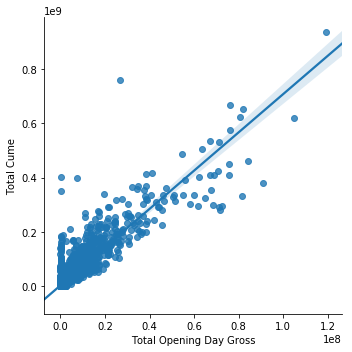

In [28]:
# These are correlated, but other grosses #s are effectively different y values. 
sns.lmplot(x = 'Total Opening Day Gross', y = 'Total Cume', data = df.loc[df['Rating']!=''])

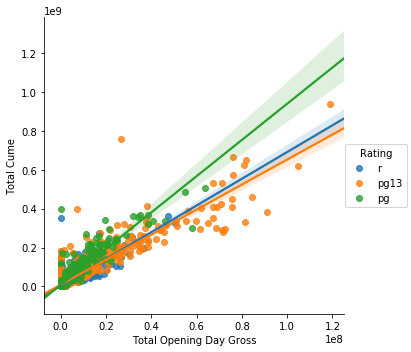

In [29]:
# Let's look at the same data, sliced by rating 
sns.lmplot(x = 'Total Opening Day Gross', y = 'Total Cume', data = df.loc[(df['Rating']=='pg13') | (df['Rating']=='r') | (df['Rating']=='pg') ], hue = 'Rating')

In [30]:
# Remove other y values from df for now, only focusing on total cume

# df = df.drop(["Total DVD/Video Release Window", "Total Locs At Opening", "Total Locs At Widest Release", "Total Opening 7 Day Gross", "Total Opening Wknd Avg","Total Opening Day Gross","Total Opening Wknd Gross","Total Opening Wknd Locs","Total Run Time"], axis = 1)


In [31]:
# Very, very basic first pass at an untested model: 



df_model = df.select_dtypes(include='int64') # Choose only int dtypes 

X = df_model.drop('Total Cume', axis = 1) # All variables
y = df_model['Total Cume']  # Total Cume
X_train, X_test, y_train, y_test = train_test_split(X, y) 

lgr = LogisticRegression()
lgr.fit(X_train,y_train)
lgr.score(X_train,y_train)

0.3996627318718381

## What's next? 
Mine other metadata
* Critics reviews pre-release (NLP)
* Optimize model, explore other model options 

# FIN